In [1]:
# Import packages

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils
import wf_psf.script_utils as wf_script_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# Model parameters

In [2]:
args = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/interp_SEDs/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_0.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_8_bins.npy',
    'n_zernikes': 45,
    'pupil_diameter': 256,
    'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'total_cycles': 9,
    'chkp_save_path':'../wf-outputs/chkp/9_cycles_HD/chkp_poly_9_cycles_256_hd_proj_reset_eval_param_0_cycle%d',
    }

In [3]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(45, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [4]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

## Ground truth WFE

In [5]:
# Select any star from the 2000 test stars and generate GT WFE
test_star = 188
test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]
# ignore first order
param_opd_maps_GT = tf.tensordot(tf_zernike_cube_gt[1:], tf.constant(test_dataset['zernike_coef'][test_star,1:,0],dtype=tf.float32), axes=[0,0])


## Load the models and generate the WFE maps

In [6]:
weights_paths = args['chkp_save_path']
WFE_list = []

for cycle_idx in range(args['total_cycles']):
    tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )
    # Load the model's weights and project
    tf_semiparam_field.load_weights(weights_paths % (cycle_idx+1)).expect_partial()
    tf_semiparam_field.project_DD_features(tf_zernike_cube)
    
    # Parametric WFE
    zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
    zernike_coeffs=np.array(zernike_coeffs)
    zernike_coeffs[0,0,0,0] = 0
    param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
    
    WFE_list.append(param_opd_maps)   
    

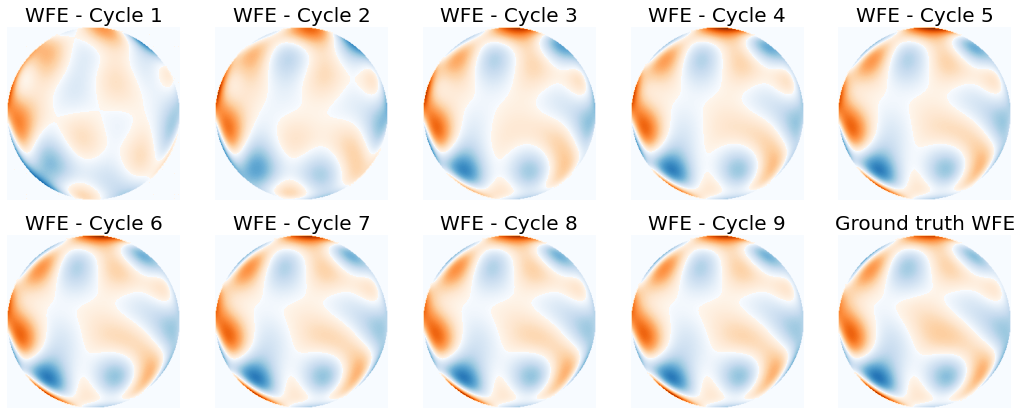

In [7]:
fig, ax =  plt.subplots(2,5,figsize=(18,7))

vmax=0.5

for idx in range(args['total_cycles']):
    ax_x=0 if idx<5 else 1
    ax_y=idx if idx<5 else (idx-5)
    im = ax[ax_x, ax_y].imshow(WFE_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    #plt.colorbar(im, ax=ax[ax_x, ax_y])
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('WFE - Cycle %d' % (idx+1), fontsize=20)

ax[1,4].imshow(param_opd_maps_GT, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1,4].axis('off')
ax[1,4].set_title('Ground truth WFE', fontsize=20)

plt.savefig('../figures/WFE_param_evolution_9_cycles.pdf')
plt.show()


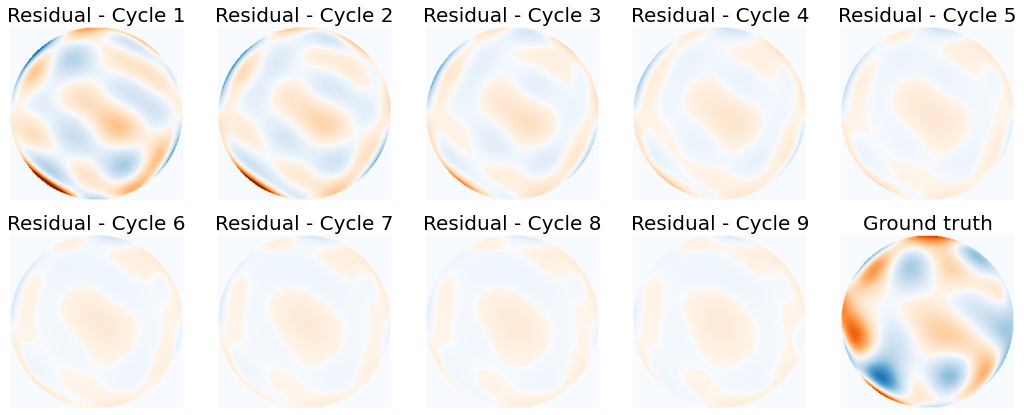

In [8]:
fig, ax =  plt.subplots(2,5,figsize=(18,7))

vmax=0.5

for idx in range(args['total_cycles']):
    ax_x=0 if idx<5 else 1
    ax_y=idx if idx<5 else (idx-5)
    im = ax[ax_x, ax_y].imshow(param_opd_maps_GT-WFE_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    #plt.colorbar(im, ax=ax[ax_x, ax_y])
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Residual - Cycle %d' % (idx+1), fontsize=20)

ax[1,4].imshow(param_opd_maps_GT, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1,4].axis('off')
ax[1,4].set_title('Ground truth', fontsize=20)

plt.savefig('../figures/WFE_param_evolution_RESIDUAL_9_cycles.pdf')
plt.show()

## Non parametric WFE

In [9]:
weights_paths = args['chkp_save_path']
WFE_non_param_list = []

for cycle_idx in range(args['total_cycles']):
    tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )
    # Load the model's weights and project
    tf_semiparam_field.load_weights(weights_paths % (cycle_idx+1)).expect_partial()
    #tf_semiparam_field.project_DD_features(tf_zernike_cube)
    
    # Non parametric WFE
    nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
    
    WFE_non_param_list.append(nonparam_opd_maps)   

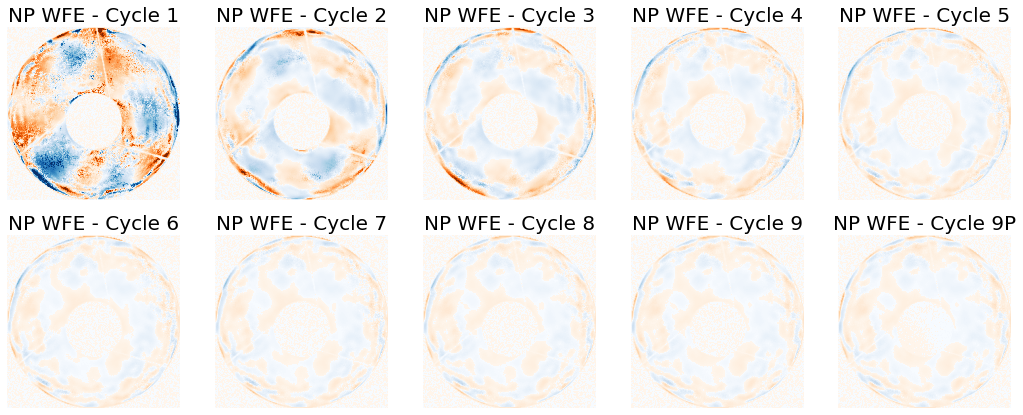

In [9]:
fig, ax =  plt.subplots(2,5,figsize=(18,7))

vmax=0.5

for idx in range(args['total_cycles']):
    ax_x=0 if idx<5 else 1
    ax_y=idx if idx<5 else (idx-5)
    im = ax[ax_x, ax_y].imshow(WFE_non_param_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    #plt.colorbar(im, ax=ax[ax_x, ax_y])
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('NP WFE - Cycle %d' % (idx+1), fontsize=20)

# Project and get non-param wfe for the last cycle
tf_semiparam_field.project_DD_features(tf_zernike_cube)
# Non parametric WFE
nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)


ax[1,4].imshow(nonparam_opd_maps[0], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1,4].axis('off')
ax[1,4].set_title('NP WFE - Cycle 9P', fontsize=20)

plt.savefig('../figures/WFE_non_param_evolution_9_cycles.pdf')
plt.show()

## Full prediction

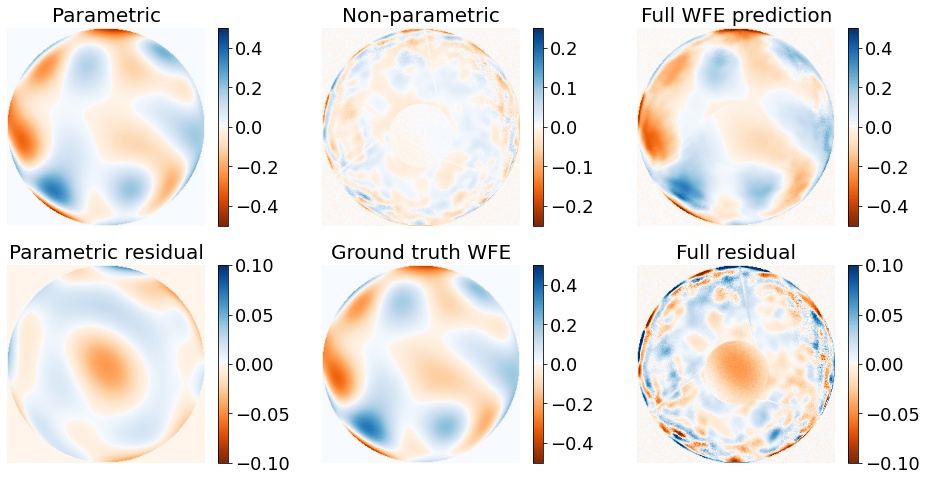

In [37]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )
# Load the model's weights and project
tf_semiparam_field.load_weights(weights_paths % (9)).expect_partial()
tf_semiparam_field.project_DD_features(tf_zernike_cube)

# Non parametric WFE
nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
full_opd_map = WFE_list[-1][0] + nonparam_opd_maps[0]



fig, ax = plt.subplots(2,3,figsize=(16,8))
cbar_ticks_size = 18

im = ax[0][0].imshow(WFE_list[-1][0],cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][0].set_title('Parametric', fontsize=20)
cbar = plt.colorbar(im,ax=ax[0][0])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[0][0].axis('off')

im = ax[0][1].imshow(full_opd_map-WFE_list[-1][0],cmap=newcmp, vmax=vmax/2, vmin=-vmax/2)
ax[0][1].set_title('Non-parametric', fontsize=20)
cbar=plt.colorbar(im,ax=ax[0][1])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[0][1].axis('off')

im = ax[0][2].imshow(full_opd_map,cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][2].set_title('Full WFE prediction', fontsize=20)
cbar=plt.colorbar(im,ax=ax[0][2])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[0][2].axis('off')



im = ax[1][0].imshow(param_opd_maps_GT-WFE_list[-1][0],cmap=newcmp, vmax=vmax/5, vmin=-vmax/5)
ax[1][0].set_title('Parametric residual', fontsize=20)
cbar = plt.colorbar(im,ax=ax[1][0])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[1][0].axis('off')

im = ax[1][1].imshow(param_opd_maps_GT,cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][1].set_title('Ground truth WFE', fontsize=20)
cbar=plt.colorbar(im,ax=ax[1][1])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[1][1].axis('off')

im = ax[1][2].imshow(param_opd_maps_GT-full_opd_map,cmap=newcmp, vmax=vmax/5, vmin=-vmax/5)
ax[1][2].set_title('Full residual', fontsize=20)
cbar=plt.colorbar(im,ax=ax[1][2])
cbar.ax.tick_params(labelsize=cbar_ticks_size)
ax[1][2].axis('off')

plt.savefig('../figures/WFE_final_9_cycles.pdf')
plt.show()